In [1]:
#from multiprocessing import set_start_method
#set_start_method("spawn")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *
from fastai2.vision.all import *
import gc
from itertools import product
from scipy import signal
import seaborn as sns

In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

In [4]:
SEGMENT_SIZE      = 500_000 
TEST_SEGMENT_SIZE = 100_000

WINDOW_SIZE = 1000
BIAS_RANGE = 0.1
CONV_KERNEL = 3
CONV_DEPTH  = 6
FILTERS = 512

BS = max(1,torch.cuda.device_count()) * 256
HIST_BINS = 128
SPLITS = 5
XTRA_DS = False

FEAT_WINDOW = 1

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

# Read data

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
train_drift = np.zeros_like(df_train['drift'])
train_drift[1:] = df_train['drift'][:-1]
df_train['signal'] =df_train['signal']-train_drift

In [7]:
test_drift = np.zeros_like(df_test['drift'])
test_drift[1:] = df_test['drift'][:-1]
df_test['signal'] = df_test['signal']-test_drift

In [8]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
if XTRA_DS: df_train = pd.concat((df_train,df_train_xtra), axis=0)

In [9]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   #torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   #torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)
                  ))

In [10]:
test.shape

torch.Size([1, 2000000])

In [11]:
test[0,:3],test[0,TEST_SEGMENT_SIZE-3:TEST_SEGMENT_SIZE+3],test[0,-3:]

(tensor([-2.6498, -2.8494, -2.8601]),
 tensor([-2.6944, -2.2560, -2.4560,  0.4461,  0.6579,  1.2465]),
 tensor([-2.8285, -2.9092, -2.7422]))

In [17]:
test_clean  = np.load(str(p_input / '3_x_sin_50hz_test.npy'))
train_clean = np.load(str(p_input / '3_x_sin_50hz_train.npy'))

In [18]:
test[0] = Tensor(test_clean)
train[0] = Tensor(train_clean)

(tensor([2.9037, 3.1372, 3.5724]), tensor([3.5437, 3.2866, 3.3446]))

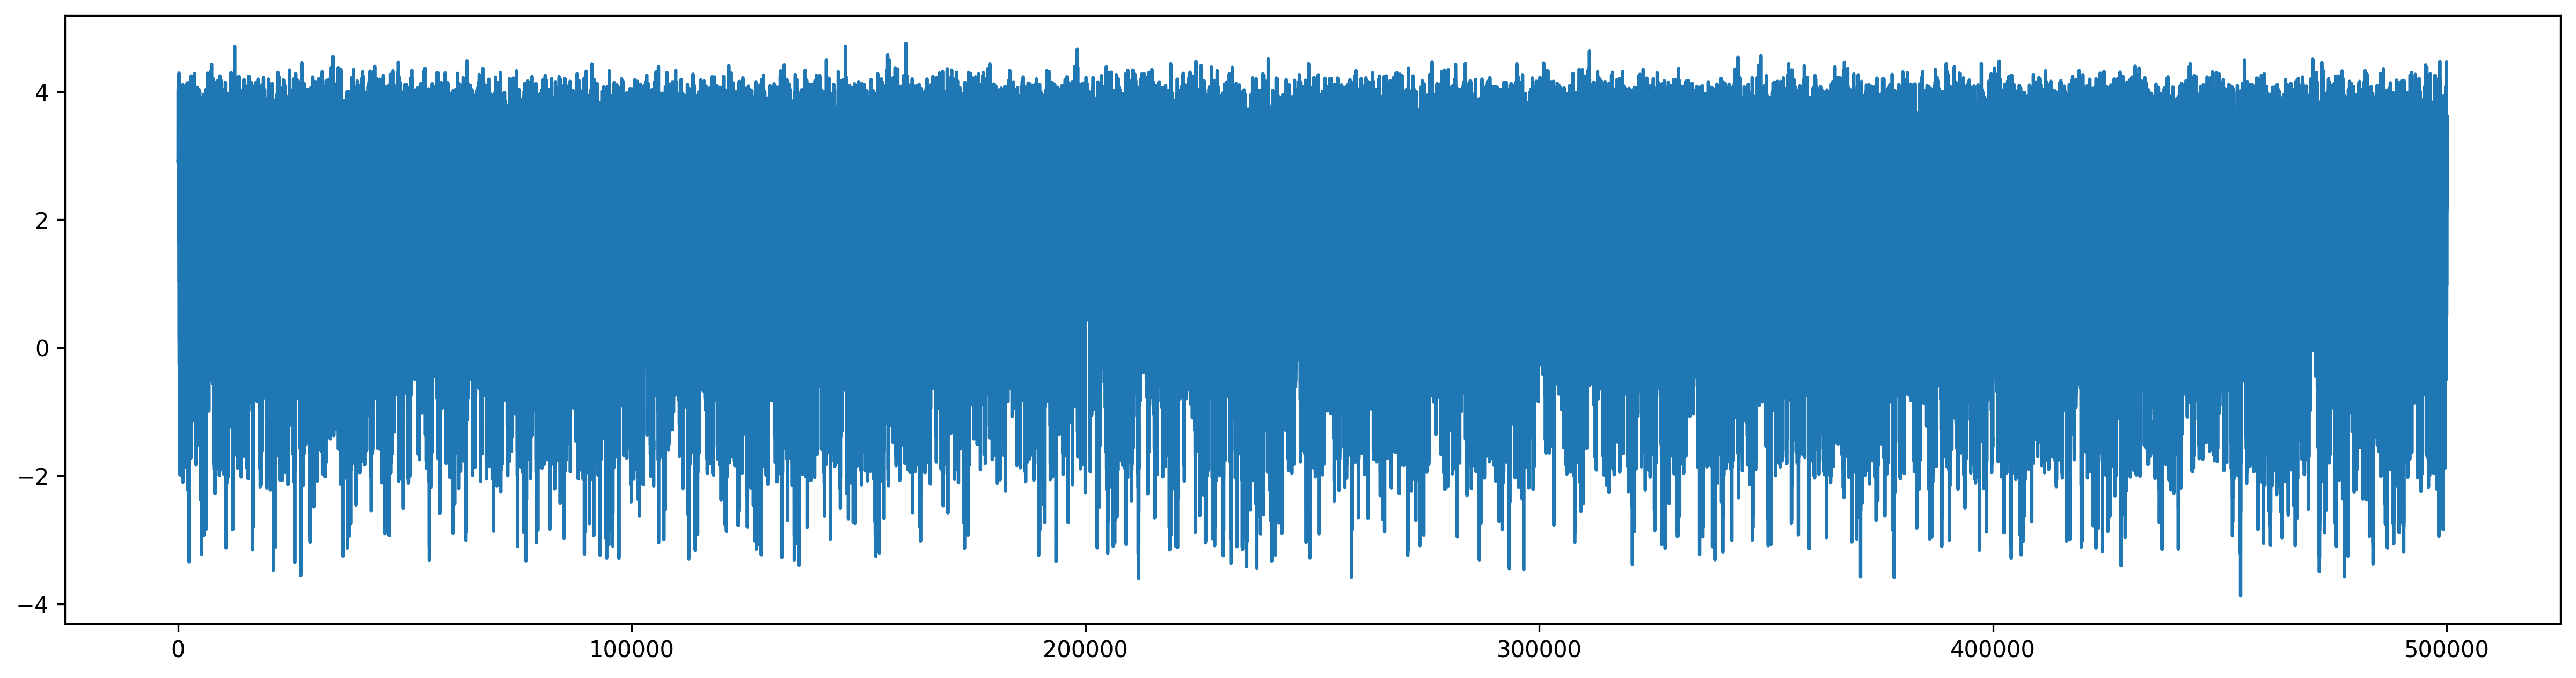

In [24]:
v = train.view(-1,SEGMENT_SIZE)[5].flatten()
plt.plot(v)
v[:3],v[-3:]
# 0 -> tiene 1 a la derecha tensor([-2.7018, -2.9021, -2.9132]), tensor([-2.6448, -2.2073,  0.5308])
# 1 -> tiene 1 a la derecha tensor([0.4947, 0.7075, 1.2971]), tensor([-1.3467,  1.0918,  4.0288])
# 2 -> ok                   tensor([3.5391, 3.0217, 3.2449]), tensor([3.0148, 3.6597, 3.5583])
# 3 -> ok                   tensor([-2.7539, -2.6119, -2.9998]), tensor([-1.8411, -1.4640, -1.3651])
# 4 -> tiene 1 a la derecha tensor([-1.3653, -1.7875, -1.2660]), tensor([-1.4518, -1.6149,  1.5762])
# 5 -> ok                          [6.5288, 6.8765, 7.5954]), tensor([4.7790, 3.6911, 3.4404])
# 6 -> tiene pico a la derecha     [3.3252, 2.7811, 3.4194]), tensor([2.1872, 2.1858, 5.1116])
# 7 -> posible pico a la derecha   [6.5214, 6.8871, 7.6502]), tensor([3.0014, 5.8755, 8.5547]
# 8 -> posible pico a la derecha   [-2.1080, -2.7463, -2.7773]), tensor([-2.2898, -3.0290,  0.3246])
# 9 -> ok                          [1.1031, 1.0392, 1.0167]), tensor([-0.1784, -0.0611, -0.2570])
# 10,

# Synth

In [25]:
p_synth = Path('synth')
use_memmap = True
load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')

try:
    high = load_fn(str(p_synth / 'high.npy'))
    low  = load_fn(str(p_synth / 'low.npy'))
except:
    high   = pd.read_csv(p_synth / 'high.csv',header=None).values.astype('uint8')
    low    = pd.read_csv(p_synth /  'low.csv',header=None).values.astype('uint8')
    np.save(str(p_synth / 'high.npy'), high)
    np.save(str(p_synth /  'low.npy'),  low)
high = high.reshape(-1,SEGMENT_SIZE)
low  =  low.reshape(-1,SEGMENT_SIZE)

In [26]:
def get_synth_segment_y(states,max_channels,size=SEGMENT_SIZE):
    y = torch.zeros((size,),dtype=torch.uint8)
    states = {'l':low, 'h':high }[states]
    for ii,i in enumerate(np.random.choice(states.shape[0],max_channels,replace=False)):
        o = np.random.randint(1+max(0,SEGMENT_SIZE-size))
        y += states[i,o:o+size]
    return y.clamp(0, 10)
y=get_synth_segment_y('h',10,SEGMENT_SIZE)
np.bincount(y,minlength=11)
# (low,1), (low,1), (high,1), (high,3), (high,10), (high,5), (high,1), (high,3), (high,5), (high,10)

array([     0,     44,    529,   3638,  15385,  46010,  94184, 132505,
       122446,  67996,  17263])

In [27]:
for i in range(10): print(np.bincount(get_synth_segment_y('l',5,SEGMENT_SIZE//5),minlength=11))

[80671 17802  1527     0     0     0     0     0     0     0     0]
[87523 11198  1279     0     0     0     0     0     0     0     0]
[86515 12966   519     0     0     0     0     0     0     0     0]
[83551 15114  1308    27     0     0     0     0     0     0     0]
[83376 16129   495     0     0     0     0     0     0     0     0]
[90482  7839  1239   440     0     0     0     0     0     0     0]
[81608 16950  1426    16     0     0     0     0     0     0     0]
[91516  8423    61     0     0     0     0     0     0     0     0]
[85976 13072   952     0     0     0     0     0     0     0     0]
[94799  5201     0     0     0     0     0     0     0     0     0]


In [28]:
# -0.12838999,49.9232689,1.73201717

test_std_by_type = {('l', 3): [0.23856227099895477,
              0.2386934608221054,
              0.23847833275794983,
              0.23833979666233063,
              0.24214892089366913,
              0.24653472006320953,
              0.2441188395023346],
             ('h', 3): [0.2698204517364502, 0.2679280936717987],
             ('h', 5): [0.27920418977737427, 0.27736446261405945],
             ('l', 4): [0.23756568133831024,
              0.24620571732521057,
              0.24222536385059357],
             ('h', 1): [0.2443782091140747],
             ('h', 10): [0.3530166447162628, 0.3537397086620331],
             ('l', 2): [0.23785734176635742,
              0.2443142682313919,
              0.24280819296836853]}

# dontuse
train_std_by_type = {('l', 1): [0.24494057893753052, 0.24666039645671844],
             ('h', 1): [0.24493855237960815, 0.2448280304670334],
             ('h', 3): [0.2653164863586426],
             ('h', 10): [0.40350663661956787, 0.40268251299858093],
             ('h', 5): [0.285168319940567, 0.28274670243263245]}

train_std_by_type = {('l', 1): [0.24515989422798157, 0.24703997373580933],
             ('h', 1): [0.24486009776592255, 0.2447292059659958],
             ('h', 3): [0.265836238861084],
             ('h', 10): [0.4045635759830475, 0.40377894043922424],
             ('h', 5): [0.28642651438713074, 0.28378984332084656]}

def get_synth_segment_xy(states,max_channels,size=SEGMENT_SIZE,add_ac=False,y=None,add_noise=True,add_bias=True):
    kernel = tensor([-1.6590e-03, -1.1617e-04, -1.0344e-03,  8.4467e-04, -9.7054e-04,
              1.4413e-03,  6.5739e-03,  2.8979e-02,  1.2115e+00, -1.0717e-03,
             -3.8138e-03,  6.0101e-04,  1.2317e-04,  3.1660e-03, -8.8741e-04,
              3.2797e-04,  2.5820e-03, -2.3032e-03])
    dim_k = kernel.numel()
    if max_channels is None: max_channels = y.max()
    bias = tensor([-5.5336 if max_channels >= 10 else -2.7708])
    if y is None: y = get_synth_segment_y(states,max_channels,size)
    y_padded = torch.zeros(y.shape[0]+dim_k-1)
    cc = (dim_k-1)//2
    y_padded[cc:cc+y.shape[0]] = y.float()
    y_padded = y_padded.view(1,1,-1)
    x = (F.conv1d(y_padded,kernel.view(1,1,-1)).flatten() + bias).to(y.device)
    if add_noise:
        if add_ac:
            ac_weight,ac_freq,ac_phase = -0.12838999,50+0.2*(torch.rand(1)-0.5),2*math.pi*torch.rand(1)
            x_range = torch.arange(x.shape[0]).float().to(x.device)
            wave = (ac_weight * torch.sin( x_range * 2*math.pi/10000 * ac_freq + ac_phase))
            x += wave
        max_channels = min(max_channels,10)
        std_by_type = train_std_by_type if (states,max_channels) in train_std_by_type else test_std_by_type
        std = np.random.choice(std_by_type[(states,max_channels)])
        x += std * torch.randn(x.numel()).to(x.device)
        if add_bias: x += BIAS_RANGE*(2*torch.rand(1)-1)
    return x.unsqueeze(-1),y.unsqueeze(-1)


In [29]:
train[-1].view(-1,SEGMENT_SIZE)[0,:]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

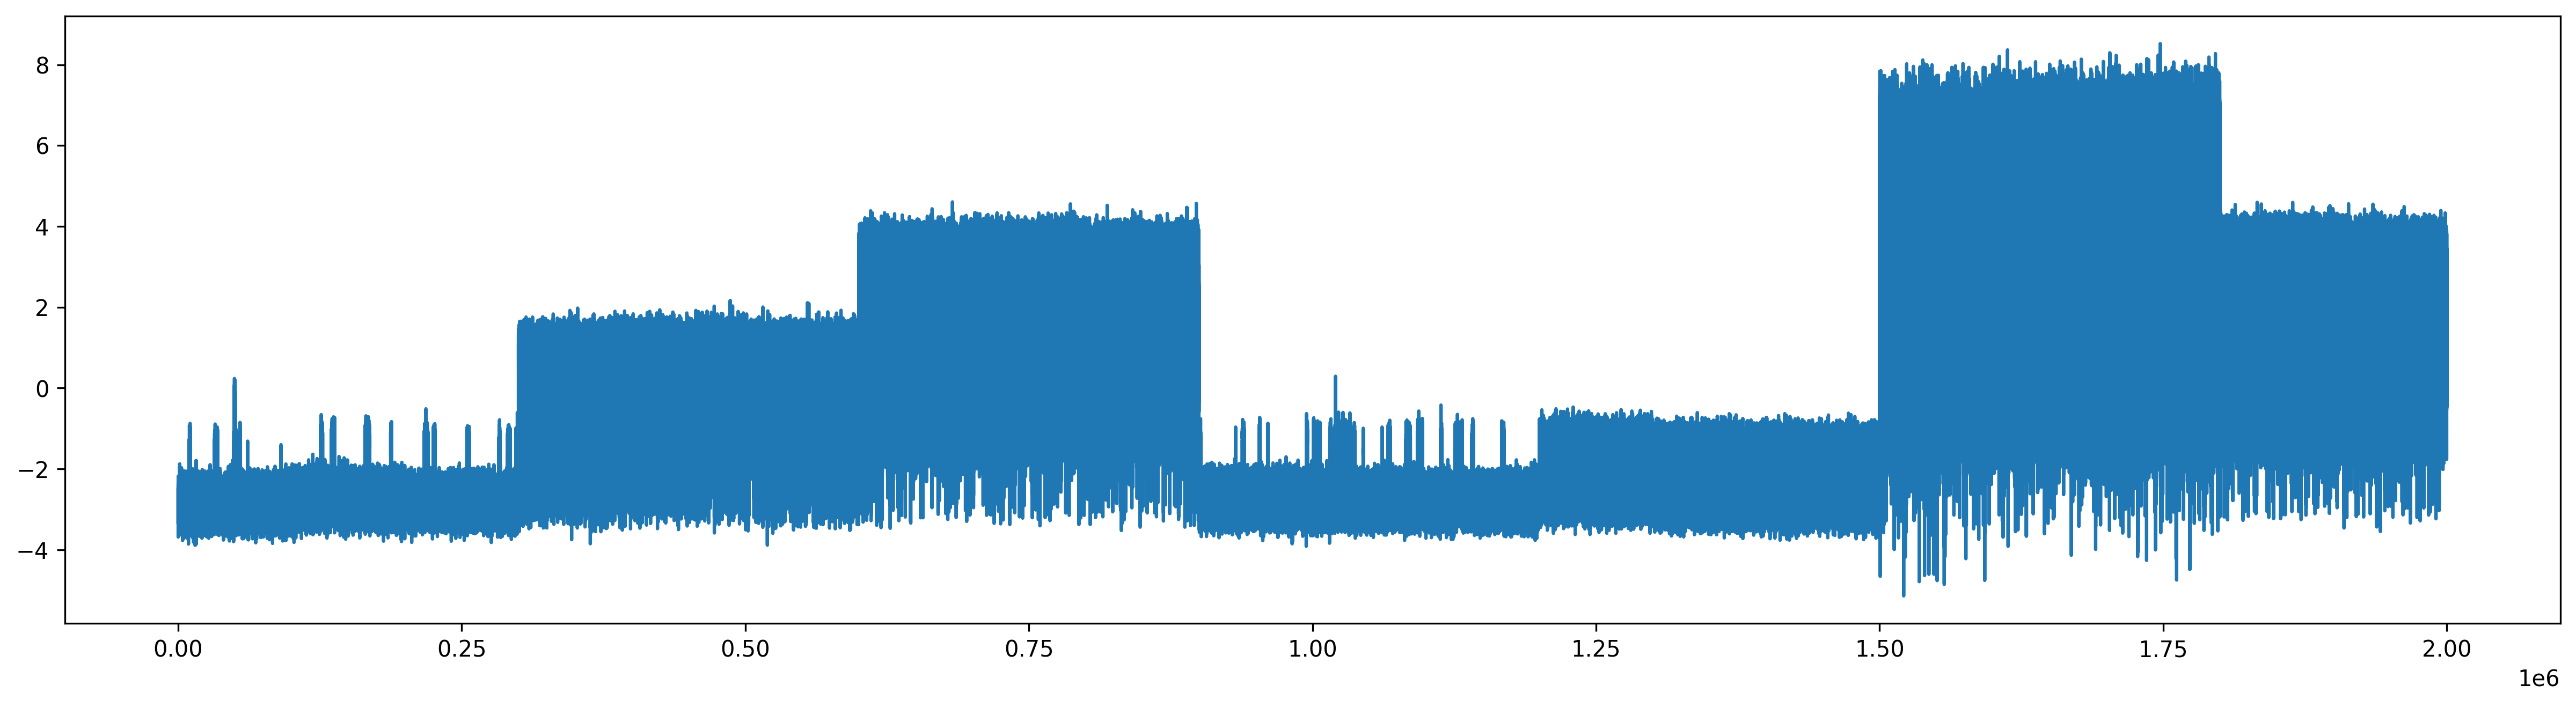

In [30]:
test_types = [('l', 3), ('h', 3), ('h', 5), ('l', 4), ('h', 1), ('h', 10), ('h', 5), ('h', 10), ('l', 3), ('h', 3),
              ('l', 3), ('l', 3), ('l', 2), ('l', 4), ('l', 4), ('l',  3), ('l', 3), ('l',  2), ('l', 2), ('l', 3)]

flatten = lambda l: [item for sublist in l for item in sublist]

test_types_x3 = flatten((i,i,i) for i in test_types)
public_types  = test_types_x3[:len(test_types)]
private_types = test_types_x3[len(test_types):]

public_s = np.nan * torch.empty(2,len(public_types),TEST_SEGMENT_SIZE,1)
for i,segment in enumerate(public_types): 
    public_s[0,i],public_s[-1,i]= get_synth_segment_xy(*segment,TEST_SEGMENT_SIZE)
plt.plot(public_s[0].flatten())

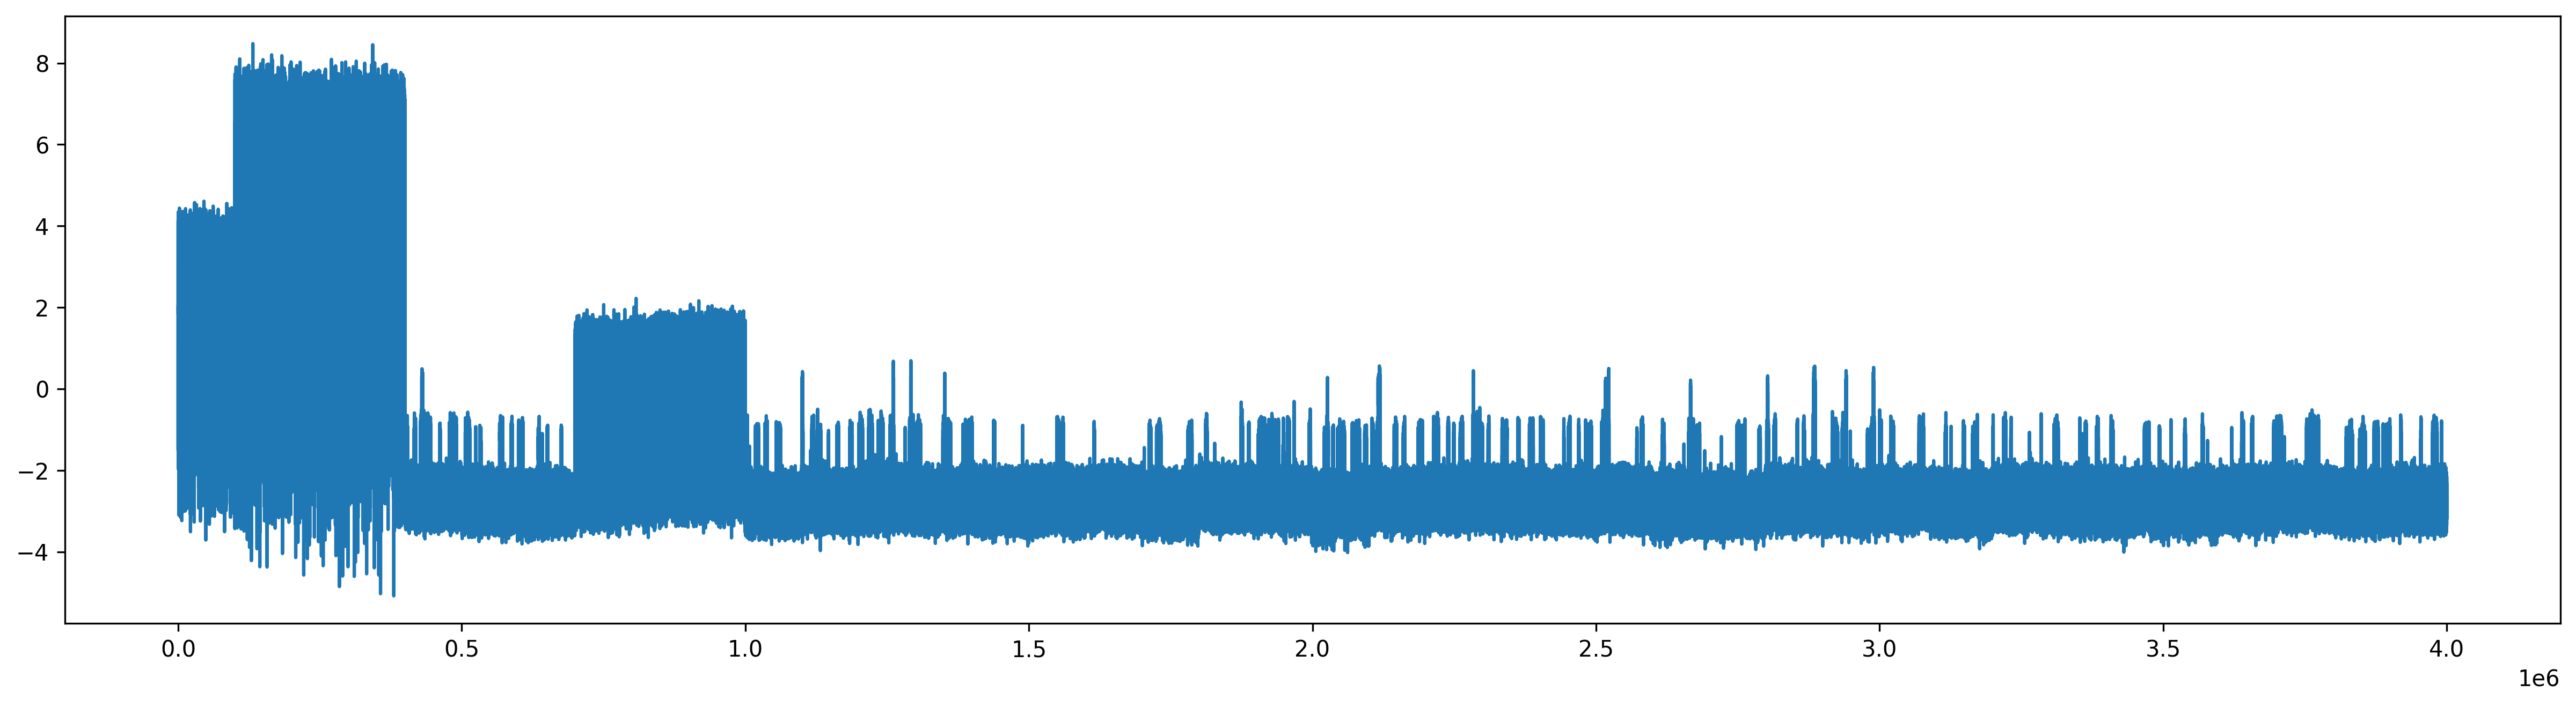

In [31]:
private_s = np.nan * torch.empty(2,len(private_types),TEST_SEGMENT_SIZE,1)
for i,segment in enumerate(private_types): 
    private_s[0,i],private_s[-1,i]= get_synth_segment_xy(*segment,TEST_SEGMENT_SIZE)
plt.plot(private_s[0].flatten())

In [32]:
# r = parallel(lambda x:get_synth_segment_xy(*x), private_types)

In [33]:
train_types=flatten([[('l', 1),('l', 2), ('l', 3), ('l', 4)],
             [('h',1)]*10,
             [('h', 3)]*20,
             [('h', 5)]*20,
             [('h', 10)]*60,]) * 10

train_types = [('l', 1),('l', 1),('h', 1),('h', 3),('h',10),('h', 5),('h', 1),('h', 3),('h', 5),('h',10),
               ('h',10),('h',10),('h',10),('h',11),('h',11),('h',12),('h',13),('h',13),('h',14),('h',14),
               ('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),('l', 3),
               ('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),('h', 5),
               ('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3),('h', 3)] * 250

train_types = public_types * 500

try:
    ltt = len(train_types)
    train_s = torch.load(f"train_s_{ltt}.npy")
    assert train_s.shape==(2,ltt,SEGMENT_SIZE,1)
except:
    train_s = np.nan * torch.empty(2,ltt,SEGMENT_SIZE,1)
    for i,segment in progress_bar(enumerate(train_types),total=len(train_types)):
        train_s[0,i],train_s[-1,i] = get_synth_segment_xy(*segment)
    torch.save(train_s,f"train_s_{ltt}.npy")

#np.bincount(train_s[2,...].flatten(),minlength=11)

# Filter 

def filter(x):
    return mne.filter.notch_filter(x.numpy().astype('float64'),10000,50.0)
train[0,:]=Tensor(filter(train[0,:]))
test[0,:] =Tensor(filter( test[0,:]))

In [34]:
train.shape,train_s.shape,test.shape

(torch.Size([2, 5000000]),
 torch.Size([2, 10000, 500000, 1]),
 torch.Size([1, 2000000]))

In [35]:
train   =   train.view(  train.shape[0],-1,SEGMENT_SIZE,1)
test    =    test.view(   test.shape[0],-1,TEST_SEGMENT_SIZE,1)

In [36]:
train = train[:,[0,1,2,3,4,5,6,8,9],...]

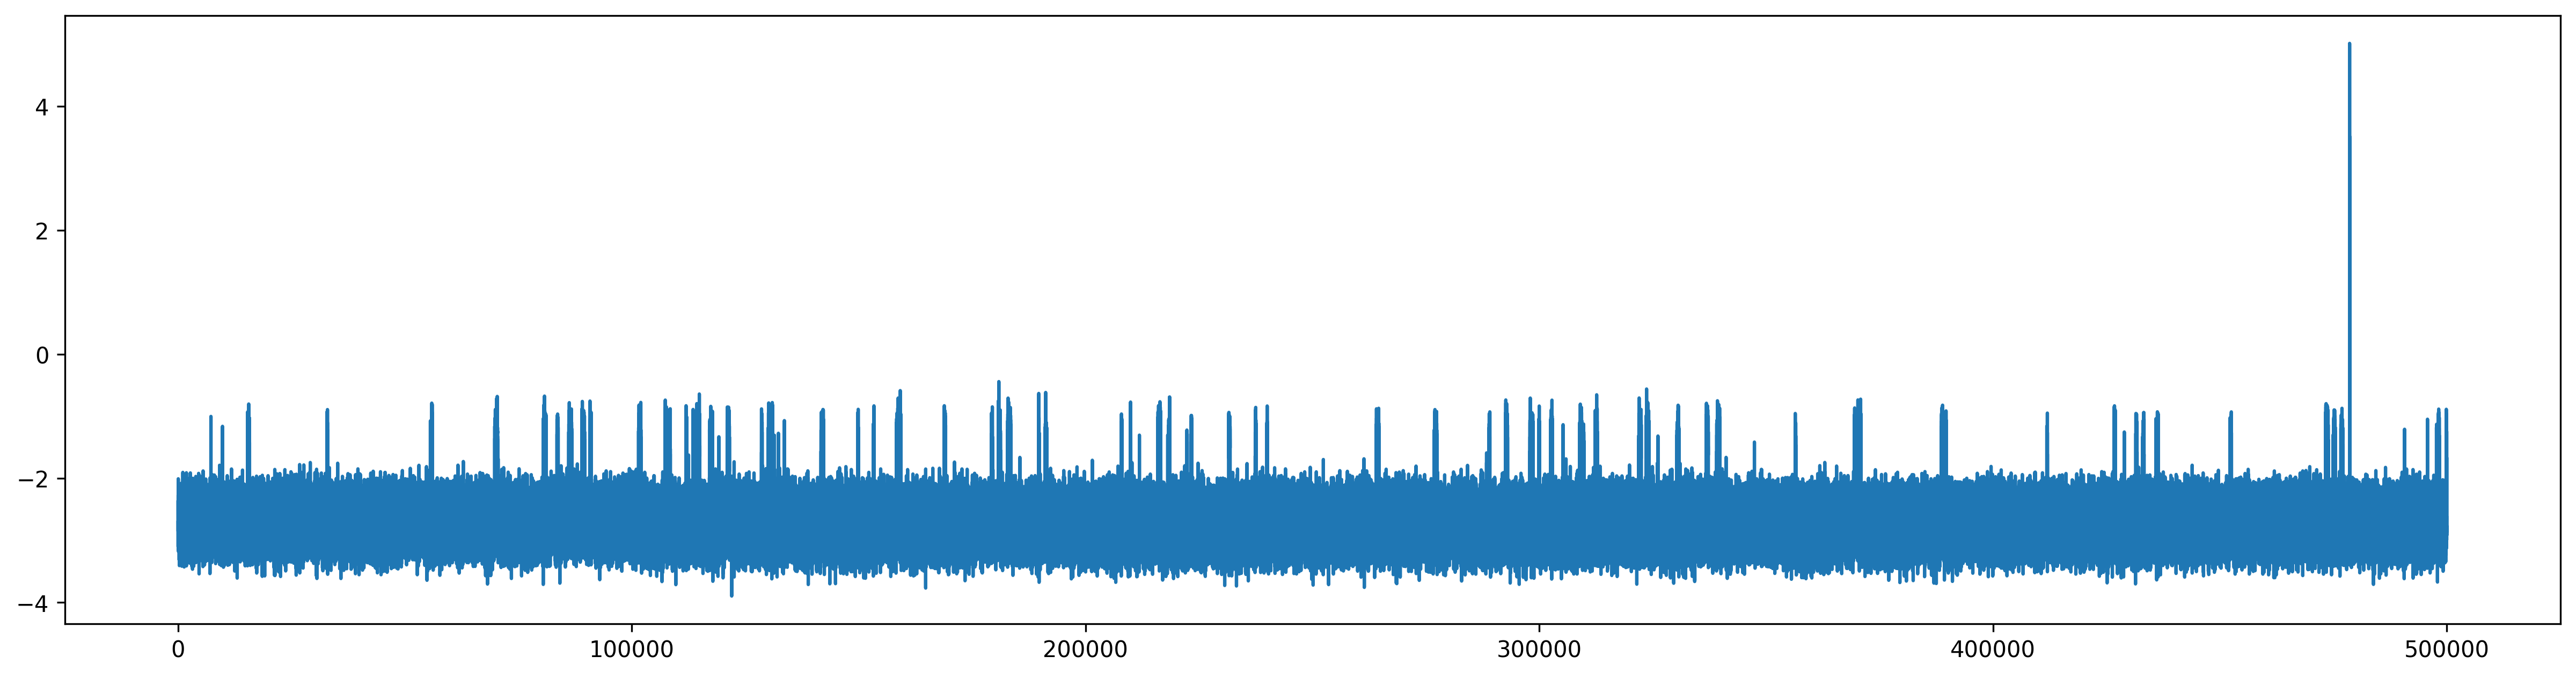

In [37]:
plt.plot(train[0,0])

# Normalize

In [38]:
signal_mean, signal_std = train[0].mean(),train[0].std()
signal_min = (min(train[0].min(), test[0].min())-BIAS_RANGE)#-signal_mean)/signal_std
signal_max = (max(train[0].max(), test[0].max())+BIAS_RANGE)#-signal_mean)/signal_std
signal_min, signal_max

(tensor(-5.8129), tensor(8.6768))

# Dataset and splits

In [39]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
windows_per_segment = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
valid_split_idx = split*split_size + np.arange(split_size)
all_segments = range(train.shape[1])
valid_idx = list(product(range(50) if XTRA_DS else all_segments,valid_split_idx))
train_idx = list(product(all_segments,windows_per_segment))
train_idx = list(sorted(set(train_idx).difference(set(valid_idx))))

In [40]:
windows_per_segment,split_size

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [41]:
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,shift=0):
        super().__init__()
        self.data, self.jitter,self.shift = data, jitter, shift
        self.segment_size = data.shape[-2]
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(self.segment_size//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 2
        self.idx_set = set(self.idx)
        self.histc = {}
        for s in range(self.data[0].shape[0]):
            x = self.data[0,s].cuda()
            if True:
                histc = torch.histc(x,bins=HIST_BINS,min=signal_min,max=signal_max)
                histc /= histc.max()
            else:
                x_max, x_min = x.max(),x.min()
                histc = torch.empty((HIST_BINS,))
                histc[2:] = torch.histc(x,bins=HIST_BINS-2,min=x_min,max=x_max)
                histc /= histc[2:].max()
                histc[0],histc[1] =  x_max, x_min
            self.histc[s] = histc.cpu()
            del x
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if ((s,(o-1)) in self.idx_set): os = -WINDOW_SIZE//2
            if ((s,(o+1)) in self.idx_set): oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        PADDING = CONV_DEPTH*(CONV_KERNEL-1)//2
        so,se = self.shift+jitter+o*WINDOW_SIZE,self.shift+jitter+(o+1)*WINDOW_SIZE
        ss_x = (torch.arange(so-PADDING,se+PADDING) % self.segment_size)
        ss_y = (torch.arange(so        ,se        ) % self.segment_size)
        x =  (self.data[0,s,ss_x,:], self.histc[s])
        if self.has_y: y_open_channels = self.data[-1,s:s+1,ss_y,0].long()
        return (x,y_open_channels) if self.has_y else (x,)

In [42]:
train_s_ds   = IonDataset(train_s,   jitter=False)
public_s_ds  = IonDataset(public_s)
private_s_ds = IonDataset(private_s)
train_ds     = IonDataset(train)
test_ds      = IonDataset(test)

In [43]:
test_ds[400][0][1]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.9378e-04, 3.5627e-03, 1.1208e-02, 3.3623e-02, 8.0903e-02,
        1.5965e-01, 2.4479e-01, 3.2925e-01, 3.4499e-01, 3.0854e-01, 2.0975e-01,
        1.2373e-01, 6.4054e-02, 5.4628e-02, 1.0777e-01, 2.4627e-01, 4.6790e-01,
        7.5610e-01, 9.5279e-01, 1.0000e+00, 8.3678e-01, 5.6780e-01, 3.0223e-01,
        1.4280e-01, 5.3218e-02, 1.5067e-02, 2.8947e-03, 1.2618e-03, 7.4223e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [44]:
class Normalize(Transform):
    parameters,order=L('mean', 'std'),99
    def __init__(self,mean,std): self.mean,self.std =mean,std
    def encodes(self,xy): return [((t[0]-self.mean) / self.std,t[1]) if i==0 else t for i,t in enumerate(xy)]

def make_ds(ds,bs=BS,shuffle=False,after_batch= Normalize(signal_mean,signal_std)):
           return DataLoader(ds, bs, shuffle=shuffle, num_workers=32, pin_memory=True, 
                             after_batch= after_batch)
            
train_s_dl   = make_ds(train_s_ds,True)
public_s_dl  = make_ds(public_s_ds)
private_s_dl = make_ds(private_s_ds)
train_dl     = make_ds(train_ds)
test_dl      = make_ds(test_ds,bs=BS//2)

dls = DataLoaders(train_s_dl, public_s_dl, test_dl, device=default_device())

# Model 

In [45]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        f = FILTERS

        self.conv = nn.Sequential(*flatten(
            [(nn.Conv1d(f if i!=0 else 1,f,CONV_KERNEL), Swish()) for i in range(CONV_DEPTH)]))
        
        self.hist = nn.Sequential(
            nn.Linear(HIST_BINS   , HIST_BINS*4), Swish(),
            nn.Linear(HIST_BINS*4 , HIST_BINS*4), Swish(),
            nn.Linear(HIST_BINS*4 , f)          , Swish(),            
        )
        
        self.lin  = nn.Sequential(
            nn.Conv1d(2*f ,2*f ,1), Swish(),
            nn.Conv1d(2*f ,2*f, 1) ,Swish(),
            nn.Conv1d(2*f ,11  ,1))
        
    def forward(self, x):
        x, hist = x 
        hist = self.hist(hist) # B HIST_BINS -> B f_hist
        hist = hist.unsqueeze(-1).expand(-1,-1,WINDOW_SIZE) # -> B f_hist WINDOW_SIZE
        x  = x.view(x.shape[0],1,-1) # B 1 WINDOW_SIZE 
        x = self.conv(x) # -> B f WINDOW_SIZE
        x = torch.cat((x,hist),dim=1) # -> B (f+f_hist) WINDOW_SIZE
        return self.lin(x).permute(0,2,1),x

In [46]:
model = Classifier()
model

Classifier(
  (conv): Sequential(
    (0): Conv1d(1, 512, kernel_size=(3,), stride=(1,))
    (1): Swish()
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (3): Swish()
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (5): Swish()
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (7): Swish()
    (8): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (9): Swish()
    (10): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (11): Swish()
  )
  (hist): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Swish()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Swish()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Swish()
  )
  (lin): Sequential(
    (0): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
    (1): Swish()
    (2): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
    (3): Swish()
    (4): Conv1d(1024, 11, kernel_size=(1,), stride=(1,))
  )
)

# Loss 

In [47]:
def softf1_loss(logits,true,weights=None,label_smoothing=0.):
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).float()
    if label_smoothing > 0: y_true = y_true *(1-label_smoothing) + label_smoothing/n_classes

    tp = (y_true * y_pred).sum(dim=0).float()
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).float()
    fp = ((1 - y_true) * y_pred).sum(dim=0).float()
    fn = (y_true * (1 - y_pred)).sum(dim=0).float()

    precision = tp / (tp + fp )
    recall    = tp / (tp + fn )

    f1 = 2* (precision*recall) / (precision + recall )
    #f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

class SoftF1Loss(Module):
    def __init__(self, label_smoothing=0,weight=None): self.weight,self.label_smoothing = weight,label_smoothing
    def forward(self, output, target): return softf1_loss(output, target, self.weight,self.label_smoothing)

class SmartLabelSmoothingCE(Module):
    def __init__(self, label_smoothing:float=0.0): 
        self.label_smoothing = Tensor([
            [0,1,0,0,0,0,0,0,0,0,0],
            [1,0,1,0,0,0,0,0,0,0,0],
            [0,1,0,1,0,0,0,0,0,0,0],
            [0,0,1,0,1,0,0,0,0,0,0],
            [0,0,0,1,0,1,0,0,0,0,0],
            [0,0,0,0,1,0,1,0,0,0,0],
            [0,0,0,0,0,1,0,1,0,0,0],
            [0,0,0,0,0,0,1,0,1,0,0],
            [0,0,0,0,0,0,0,1,0,1,0],
            [0,0,0,0,0,0,0,0,1,0,1],
            [0,0,0,0,0,0,0,0,0,1,0],
        ])
        self.label_smoothing  *= (label_smoothing / self.label_smoothing.sum(dim=1,keepdims=True))
        self.label_smoothing += (1-label_smoothing) * torch.eye(11)
        
    def forward(self, logits, true):
        n_classes = logits.size()[-1]
        y_pred = logits.view(-1,n_classes)    
        y_true = self.label_smoothing[true.flatten()].view(-1,n_classes).to(logits.device)
        return (- y_true * F.log_softmax(y_pred, dim=1)).sum(dim=1).mean()

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.65, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self, losses, weights=None):
        self.losses, self.weights = losses, ifnone(weights, [1.] * len(losses))
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_open_channels, _ = input
        t_open_channels    = target
        loss = L([l(i_open_channels,t_open_channels)*w for l,w in zip(self.losses, self.weights)]).sum()
        return loss
    
sls = SmartLabelSmoothingCE(0.1)
sls(Tensor([[[0,0,0,0,0,0,0,0,0,0,10]]]),LongTensor([[[10]]]))
SoftF1Loss()(Tensor([[[0,0,0,0,0,0,0,0,0,0,10]]]),LongTensor([[[10]]]))

tensor(0.0002)

# Metrics

In [48]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, metric_name=None, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten,metric_name')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y,learn.pred[0] #learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):
        return ifnone(self.metric_name,self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__)

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def MF1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, **kwargs):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, **kwargs)

def A(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[0],targ#inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [49]:
mets = [MF1Score(labels=[l],average='macro', metric_name=f"f1_{l}") for l in range(11)]
mets.extend([MF1Score(labels=list(range(11)),average='macro', metric_name=f"f1"), A])

# Train

In [50]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss([CrossEntropyLossFlat()]),metrics=mets, moms=None,)

#learn.callbacks.extend([F1Metric(learn)])

learn.to_parallel().to_fp16()
summary = learn.summary()
match = re.search(r'Total trainable params: ([0-9,]+)', summary)
model_params = int(match.group(1).replace(",",""))
print(summary)

Classifier (Input shape: ["['1 x 1012 x 1', '1 x 128']"])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               1 x 512 x 1010       2,048      True      
________________________________________________________________
Swish                1 x 512 x 1010       0          False     
________________________________________________________________
Conv1d               1 x 512 x 1008       786,944    True      
________________________________________________________________
Swish                1 x 512 x 1008       0          False     
________________________________________________________________
Conv1d               1 x 512 x 1006       786,944    True      
________________________________________________________________
Swish                1 x 512 x 1006       0          False     
________________________________________________________________
Conv1d               1 x 512 x 1004       786,944    True      
________________________________________

In [51]:
modelname = 'conv_swift_6638603_t5000000_v2000_BS512_SS500000_WS1000_pucv0.945299_prcv0.941465_trcv0.943609_clean_synth_clean50hz'
try:
    learn.load(modelname, strict=True)
    print(f"Loaded {modelname}")
except:
    print(f"Failed to load {modelname}")

Loaded conv_swift_6638603_t5000000_v2000_BS512_SS500000_WS1000_pucv0.945299_prcv0.941465_trcv0.943609_clean_synth_clean50hz


In [ ]:
lr_min, lr_steep=learn.lr_find(end_lr=1e-1)

In [ ]:
learn.loss_func=DriftChannelsLoss([CrossEntropyLossFlat()],[1.])
learn.fit_one_cycle(1,lr_max=2e-3,moms=(0.95, 0.85, 0.95),pct_start=0.25)

In [ ]:
learn.loss_func=DriftChannelsLoss([ SoftF1Loss()])
learn.fit_flat_cos(1,lr=1e-3,pct_start=0.5)

In [ ]:
learn.loss_func=DriftChannelsLoss([ SoftF1Loss()])
learn.fit_flat_cos(1,lr=1e-4,pct_start=0.5)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.loss_func=DriftChannelsLoss([SoftF1Loss(label_smoothing=0.),LabelSmoothingCE()],[40.,1])
learn.fit_flat_cos(1,1e-2,pct_start=0.25)

In [ ]:
learn.fit_flat_cos(1,5e-4,pct_start=0.5)

In [ ]:
learn.loss_func=DriftChannelsLoss([LabelSmoothingCE(0.75)])

In [ ]:
learn.fit_flat_cos(20,1e-3,pct_start=0.1)

In [ ]:
learn.summary()

In [52]:
public_cv = private_cv = train_cv = 0.

In [53]:
public_s_dl.device=default_device()
p = learn.get_preds(dl=public_s_dl)
y_pred = p[0][0].argmax(dim=-1).flatten()
y_true = p[1].flatten()
public_cv=skm.f1_score(y_true,y_pred,labels=range(11),average='macro')
public_cv

0.9442920437883263

In [54]:
private_s_dl.device=default_device()
p = learn.get_preds(dl=private_s_dl)
y_pred = p[0][0].argmax(dim=-1).flatten()
y_true = p[1].flatten()
private_cv=skm.f1_score(y_true,y_pred,labels=range(11),average='macro')
private_cv

0.9399606032511617

In [55]:
train_dl.device=default_device()
p = learn.get_preds(dl=train_dl)
y_pred = p[0][0].argmax(dim=-1).flatten()
y_true = p[1].flatten()
train_cv=skm.f1_score(y_true,y_pred,labels=range(11),average='macro')
train_cv

0.9436128592563615

In [ ]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

In [ ]:
suffix =  '_synth_clean50hz'

In [ ]:
modelname = f'conv_swift_{model_params}_t{len(train_s_ds)}_v{len(public_s_ds)}_BS{BS}_SS{SEGMENT_SIZE}_WS{WINDOW_SIZE}_pucv{public_cv:0.06f}_prcv{private_cv:0.06f}_trcv{train_cv:0.06f}{DATA_SUFFIX}{suffix}'
learn.save(modelname);modelname

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
private_s_dl.device=default_device()

In [ ]:
learn.model = learn.model.module.module

In [ ]:
pp = learn.get_preds(dl=private_s_dl,with_input=True)

In [ ]:
private_s_dl.dataset.data[0].shape

In [ ]:
plt.plot(pp[1][0].argmax(dim=-1).flatten()+10)
plt.plot(private_s_dl.dataset.data[0].flatten())

# Test

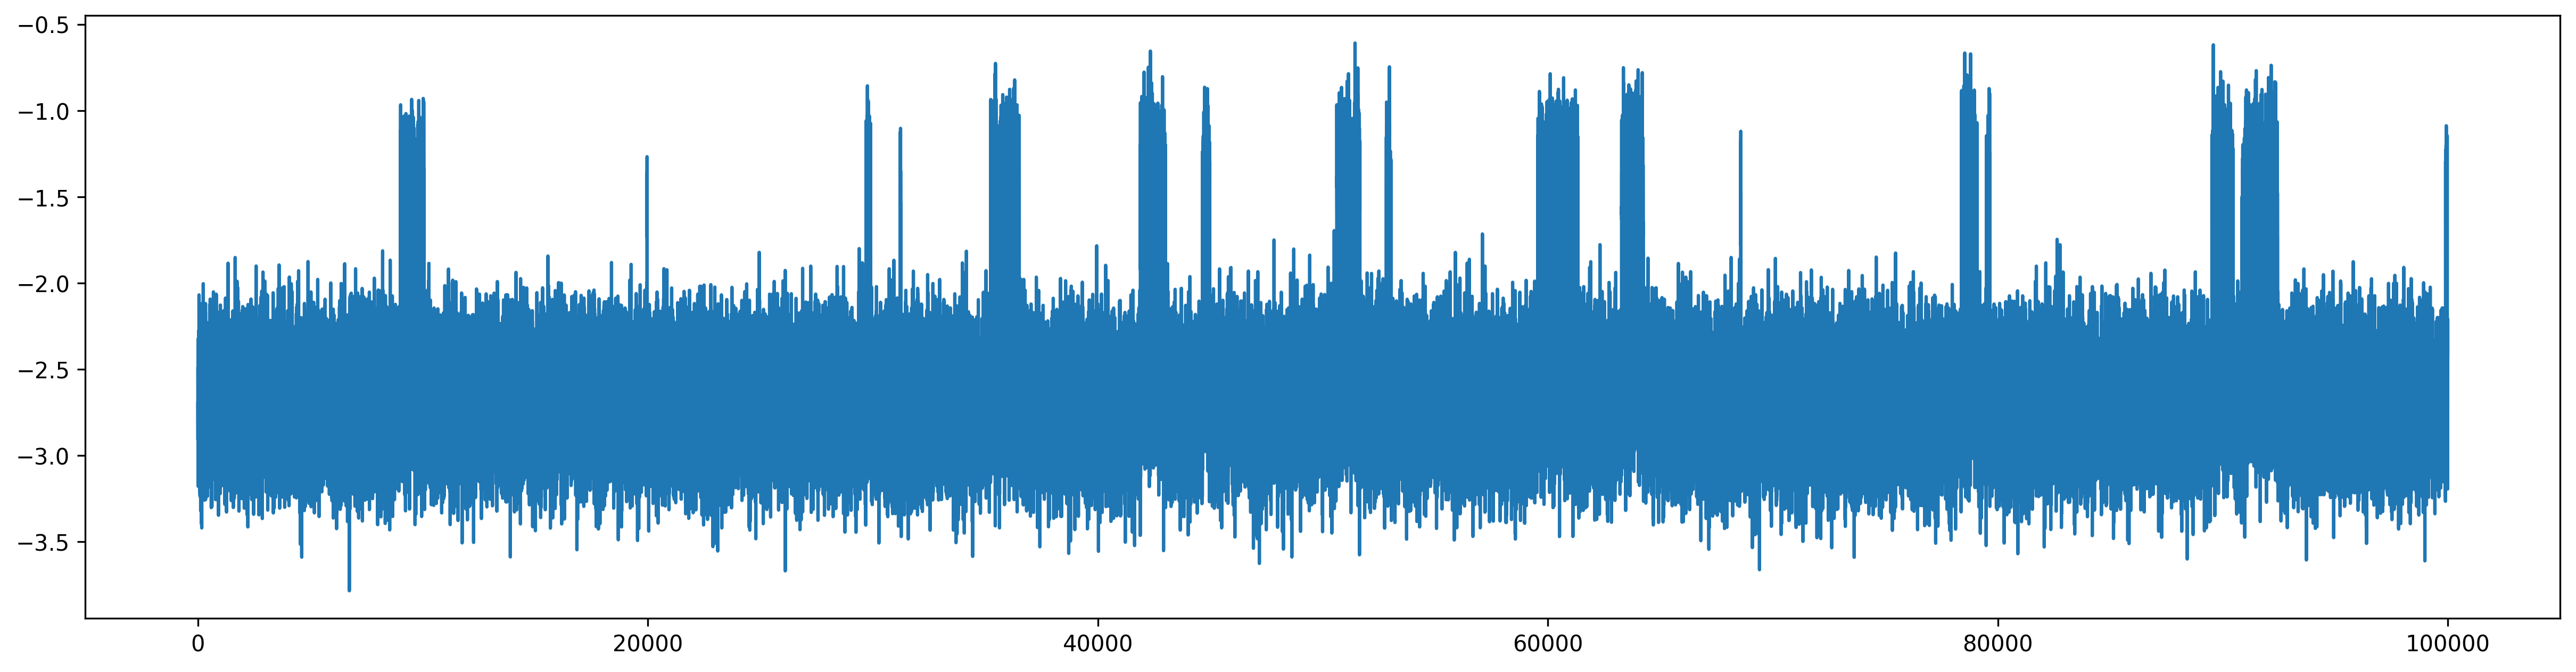

In [56]:
plt.plot(test_dl.dataset.data[0,0,:].flatten())


In [57]:
#learn.model = learn.model.module.module

In [58]:
pp = learn.get_preds(dl=test_dl,with_input=True)

In [59]:
pp[0][1][300]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2127e-04, 6.6699e-04, 3.8200e-03, 1.8615e-02, 5.8392e-02, 1.6845e-01,
        3.5678e-01, 6.3516e-01, 8.8673e-01, 1.0000e+00, 9.1093e-01, 6.6935e-01,
        3.7909e-01, 1.7354e-01, 6.7305e-02, 2.5346e-02, 2.8862e-02, 4.9175e-02,
        7.9069e-02, 1.1048e-01, 1.2655e-01, 1.1114e-01, 7.4521e-02, 4.5052e-02,
        1.9646e-02, 7.8826e-03, 3.0924e-03, 2.1222e-03, 3.5775e-03, 6.5486e-03,
        9.0347e-03, 1.0672e-02, 7.3975e-03, 6.1848e-03, 2.7286e-03, 1.5159e-03,
        5.4572e-04, 1.2127e-04, 3.6381e-04, 2.4254e-04, 6.0635e-04, 4.8508e-04,
        6.0635e-04, 5.4572e-04, 2.4254e-04, 1.2127e-04, 1.2127e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

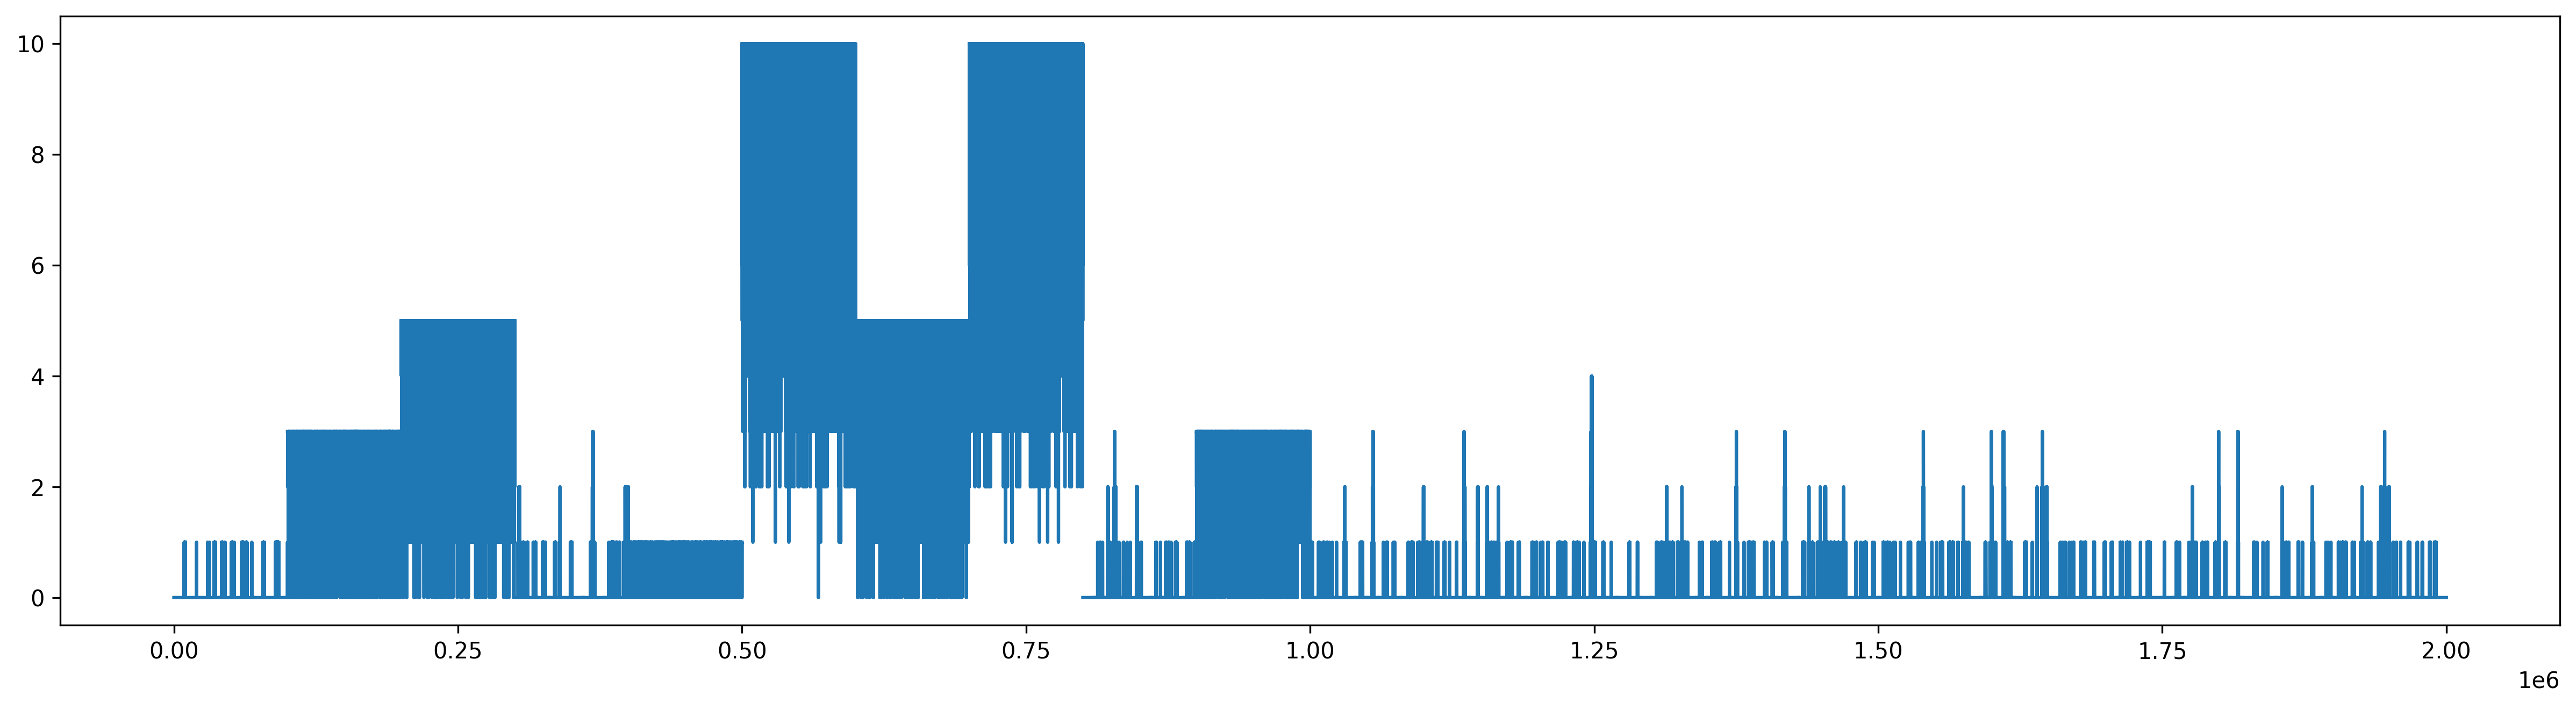

In [60]:
plt.plot(pp[1][0].argmax(dim=-1).flatten())

In [61]:
learn.model.eval()
test_preds  = torch.zeros(*test[0].squeeze().shape,11,dtype=torch.float)
test_preds_ = torch.empty_like(test_preds)
n_tta = 0
learn.model = nn.DataParallel(learn.model)
with torch.no_grad():
    mb = master_bar(np.linspace(0,WINDOW_SIZE,endpoint=False,num=5,dtype=np.int))
    for shift in mb:
        test_dl.dataset.shift = shift
        test_preds_ = test_preds_.view(-1,11)
        test_preds_[...] = 0.
        s = 0
        for xx in progress_bar(test_dl,parent=mb):
            x = xx[0]
            preds = learn.model((x[0].cuda(),x[1].cuda()))
            open_channels,_ = preds
            open_channels = open_channels.view(-1,11)
            l = open_channels.shape[0]
            test_preds_[s:s+l] += open_channels.cpu()
            s += l
        test_preds_ = test_preds_.view(-1,TEST_SEGMENT_SIZE,11)
        ss = torch.arange(0+shift,TEST_SEGMENT_SIZE+shift) % TEST_SEGMENT_SIZE
        for segment in range(test_preds_.shape[0]):
            test_preds[segment,ss] += test_preds_[segment,...]
        n_tta +=1
learn.model = learn.model.module

In [62]:
test_preds = test_preds.view(-1,11)
test_preds

tensor([[  87.9845,  -10.7924,  -72.6947,  ..., -111.5828,  -94.8607,
          -10.6305],
        [  96.2124,  -10.0510,  -78.2271,  ..., -126.3389, -106.1386,
          -12.2898],
        [  95.3047,   -8.8035,  -78.0249,  ..., -125.7074, -106.2315,
          -14.4424],
        ...,
        [  92.3056,  -11.3514,  -74.8696,  ..., -118.1291,  -99.1446,
          -10.1489],
        [  94.0004,  -10.2269,  -76.1118,  ..., -122.0162, -102.4431,
          -12.3223],
        [  89.4865,  -12.2270,  -72.8292,  ..., -112.7099,  -94.7405,
           -8.3132]])

In [63]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

torch.Size([2000000])

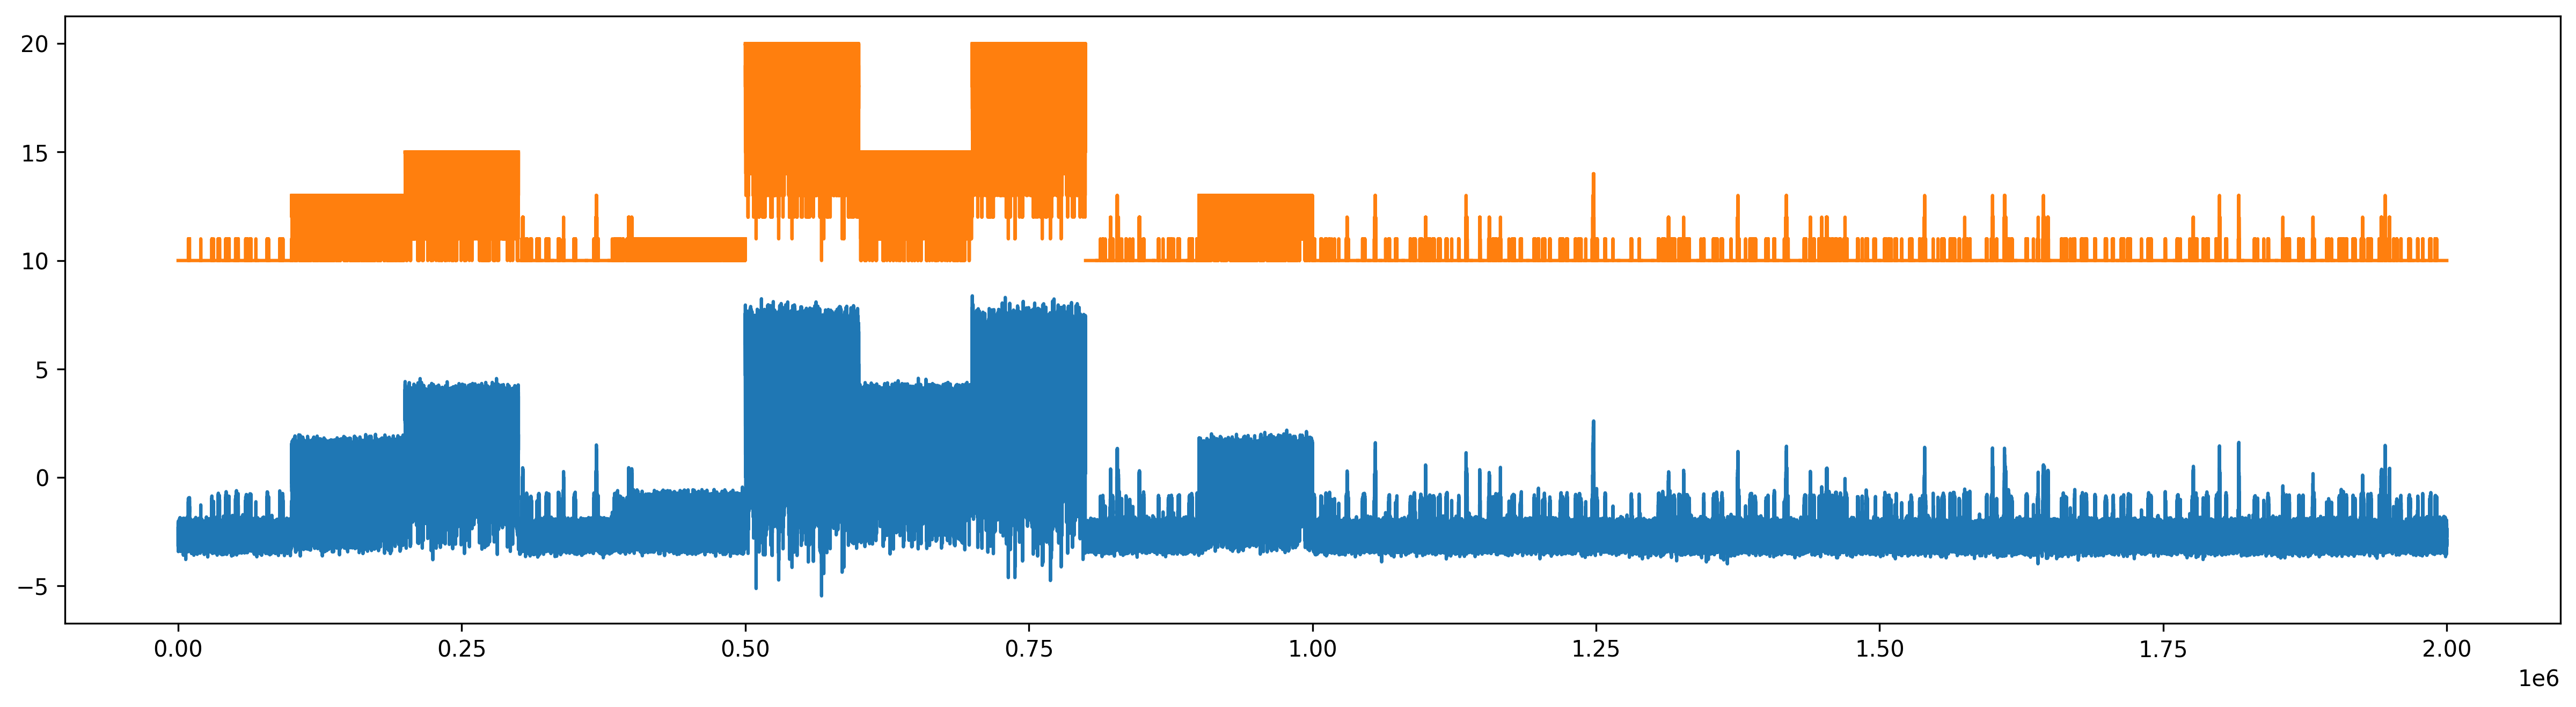

In [64]:
plt.plot(test[0,:].flatten())
plt.plot(open_channels+10)

In [65]:
m_types = [('l',1),('l',2),('l',3),('l',4),('l',5),
           ('h',1),('h',2),('h',3),('h',4),('h',5),('h',10)]
p_dist = np.zeros((len(m_types),11))
for _ in range(100):
    for i,m_type in enumerate(m_types):
        p_dist[i] += np.bincount(get_synth_segment_y(*m_type,SEGMENT_SIZE),minlength=11)/(SEGMENT_SIZE)
p_dist /= 100
ts_densities = np.array(
    [np.bincount(open_channels.view(-1,TEST_SEGMENT_SIZE)[b],minlength=11)/TEST_SEGMENT_SIZE for b in range(20)])

In [66]:
train.shape

torch.Size([2, 9, 500000, 1])

In [67]:
m_types = [('l',1),('l',2),('l',3),('l',4),('l',5),
           ('h',1),('h',2),('h',3),('h',4),('h',5),('h',10)]
p_dist = np.zeros((len(m_types),11))
for _ in range(100):
    for i,m_type in enumerate(m_types):
        p_dist[i] += np.bincount(get_synth_segment_y(*m_type,SEGMENT_SIZE),minlength=11)/(SEGMENT_SIZE)
p_dist /= 100
ts_densities = np.array(
    [np.bincount(train[-1,b].squeeze(),minlength=11)/SEGMENT_SIZE for b in range(9)])

In [68]:
ts_densities

array([[9.68268e-01, 3.17320e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [9.61324e-01, 3.86760e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.52008e-01, 7.47992e-01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.35560e-02, 1.73860e-01, 4.33766e-01, 3.68818e-01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [4.00000e-06, 1.14000e-04, 1.05200e-03, 6.85200e-03, 2.92500e-02,
        9.02900e-02, 1.85558e-01, 2.64638e-01, 2.46486e-01, 1.39300e-01,
        3.64560e-02],
       [1.91200e-03, 2.34640e-02, 1.18468e-01, 2.94666e-01, 3.75164e-01,
        1.86326e-01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.0000

In [69]:
from scipy.spatial import distance
t_types = []
for d in distance.cdist(ts_densities,p_dist): t_types.append(m_types[d.argmin()])
t_types

[('l', 1),
 ('l', 1),
 ('h', 1),
 ('h', 3),
 ('h', 10),
 ('h', 5),
 ('h', 1),
 ('h', 5),
 ('h', 10)]

In [70]:
test[0,...,0].flatten().shape,open_channels.shape

(torch.Size([2000000]), torch.Size([2000000]))

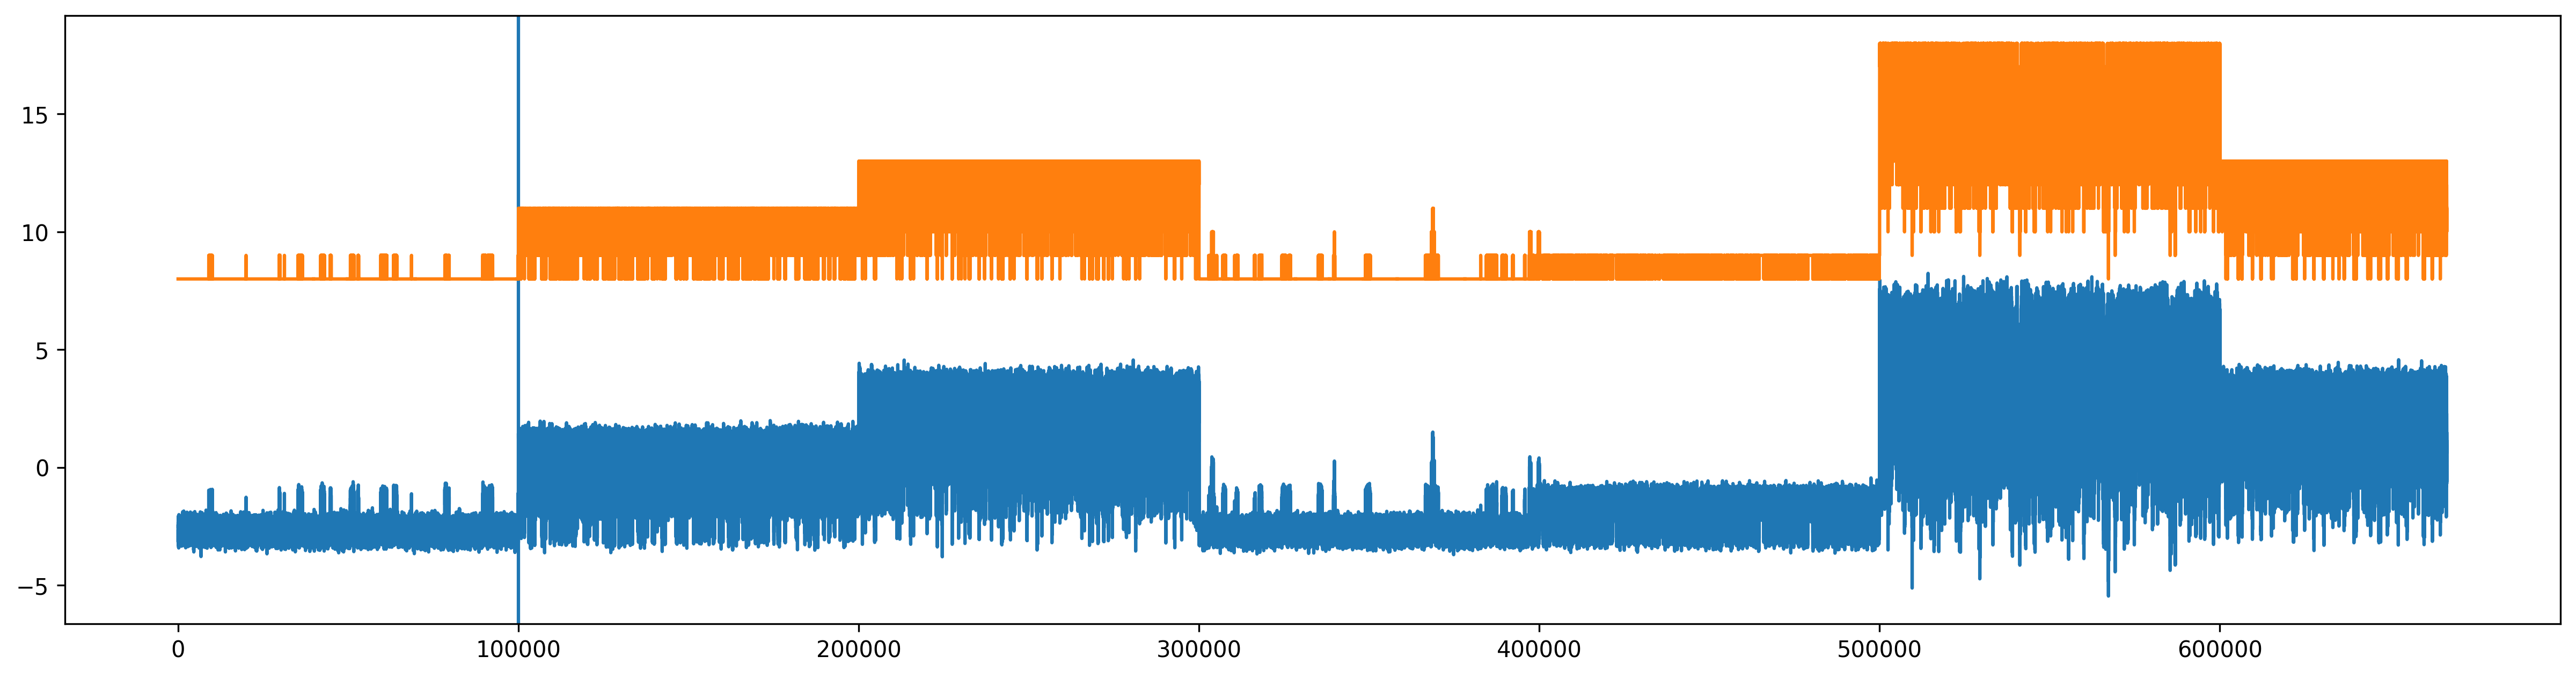

In [71]:
plt.axvline(100_000, -5, 10, label='pyplot vertical line')
plt.plot(test[0,...,0].flatten()[:2000000//3])
plt.plot(open_channels[:2000000//3]+8)


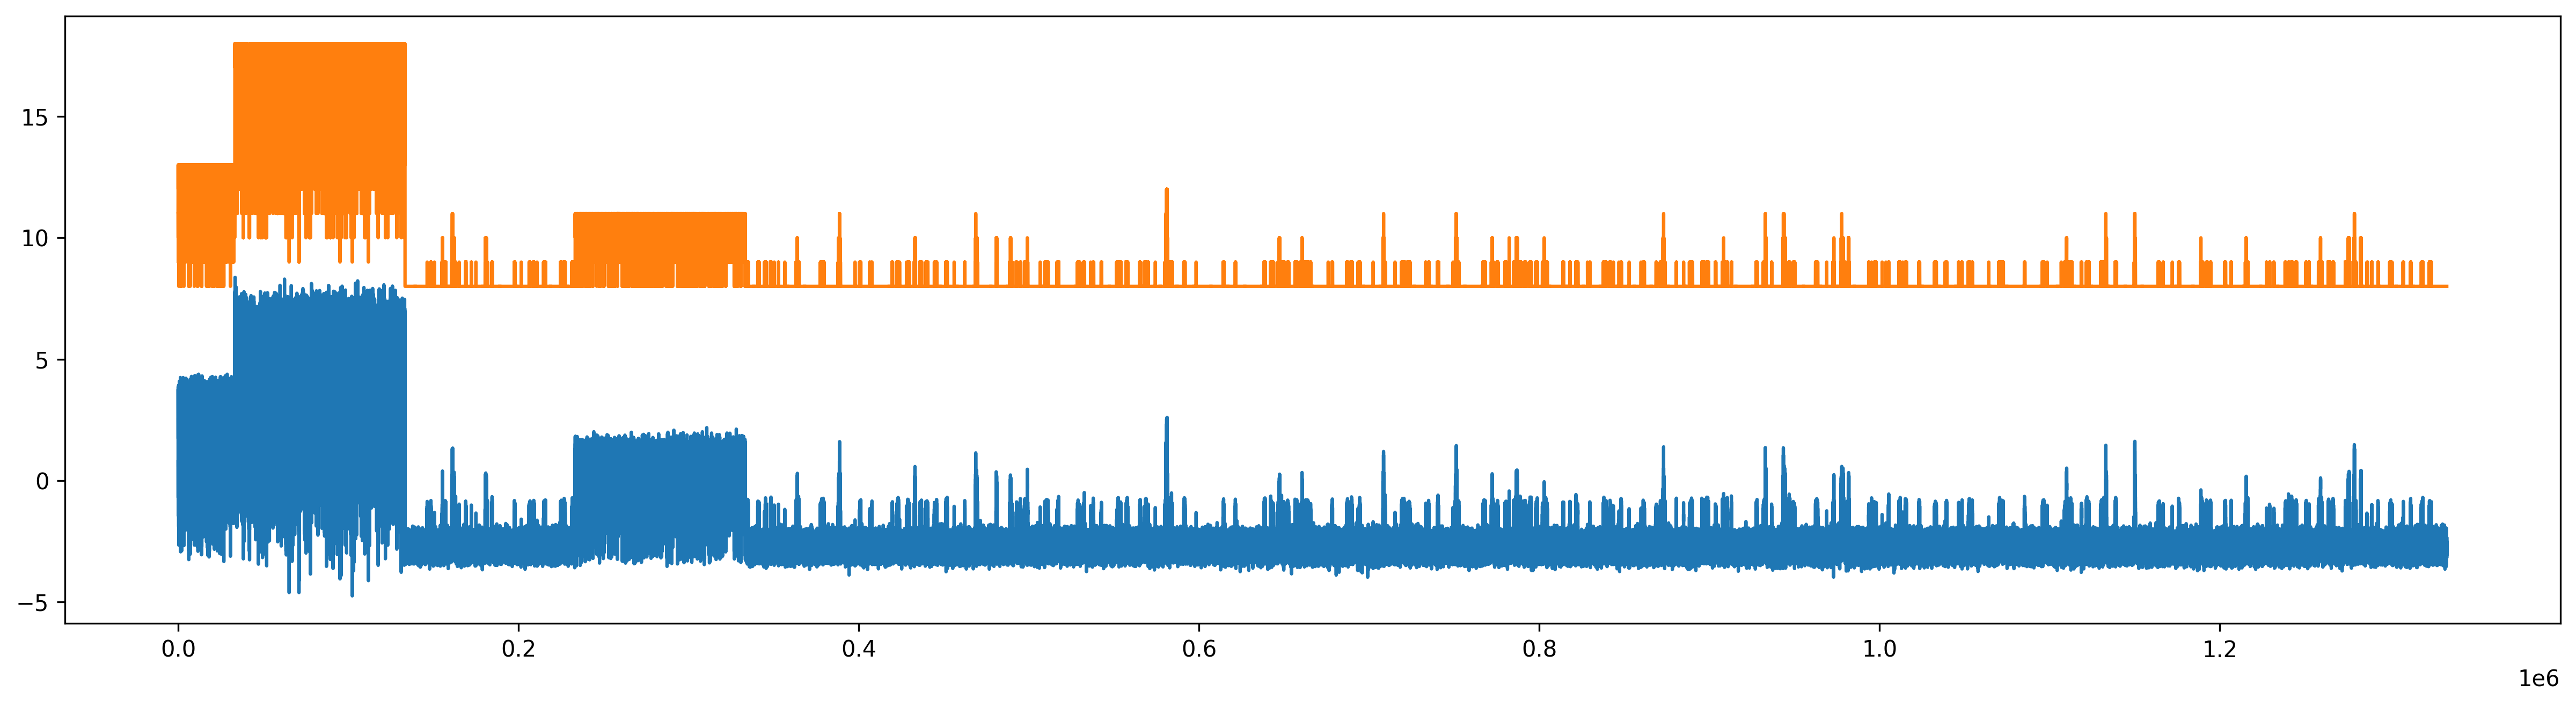

In [72]:
plt.plot(test[0,...,0].flatten()[2000000//3:])
plt.plot(open_channels[2000000//3:]+8)

In [73]:
train_types = [('l', 1),
 ('l', 1),
 ('h', 1),
 ('h', 3),
 ('h', 10),
 ('h', 5),
 ('h', 1),
 ('h', 5),
 ('h', 10)]

torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])


defaultdict(list,
            {('l', 1): [0.24515989422798157, 0.24700333178043365],
             ('h', 1): [0.24486009776592255, 0.24472913146018982],
             ('h', 3): [0.265836238861084],
             ('h', 10): [0.4045635759830475, 0.40377897024154663],
             ('h', 5): [0.28642651438713074, 0.28378981351852417]})

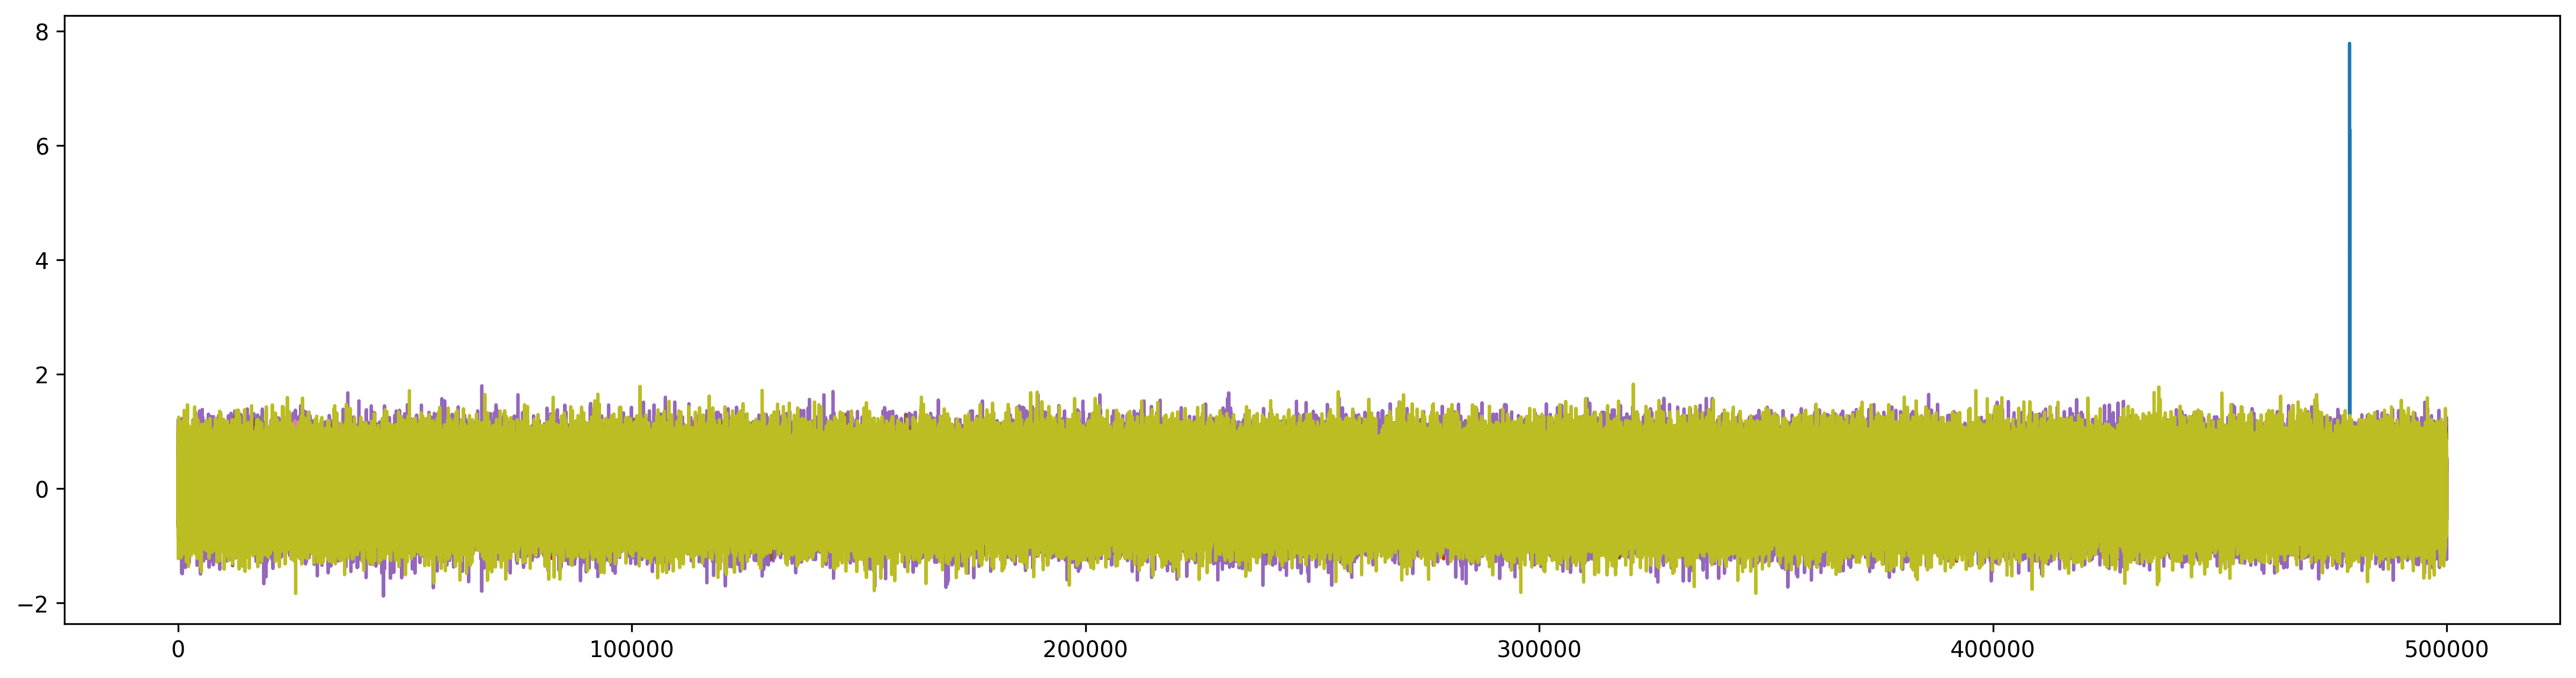

In [74]:
train_types_std = defaultdict(list)
for s,tt in enumerate(train_types):
    xs = train[ 0,s,:].flatten()
    ys = train[-1,s,:].flatten()
    print(ys.shape,xs.shape)
    x_pred = get_synth_segment_xy(None,None,size=SEGMENT_SIZE,y=ys,add_noise=False)[0].flatten()
    plt.plot(xs-x_pred)
    std = (xs-x_pred).std().item()
    train_types_std[tt].append(std)
    #plt.plot(x_pred)

train_types_std

0.2699454426765442


tensor(6407)

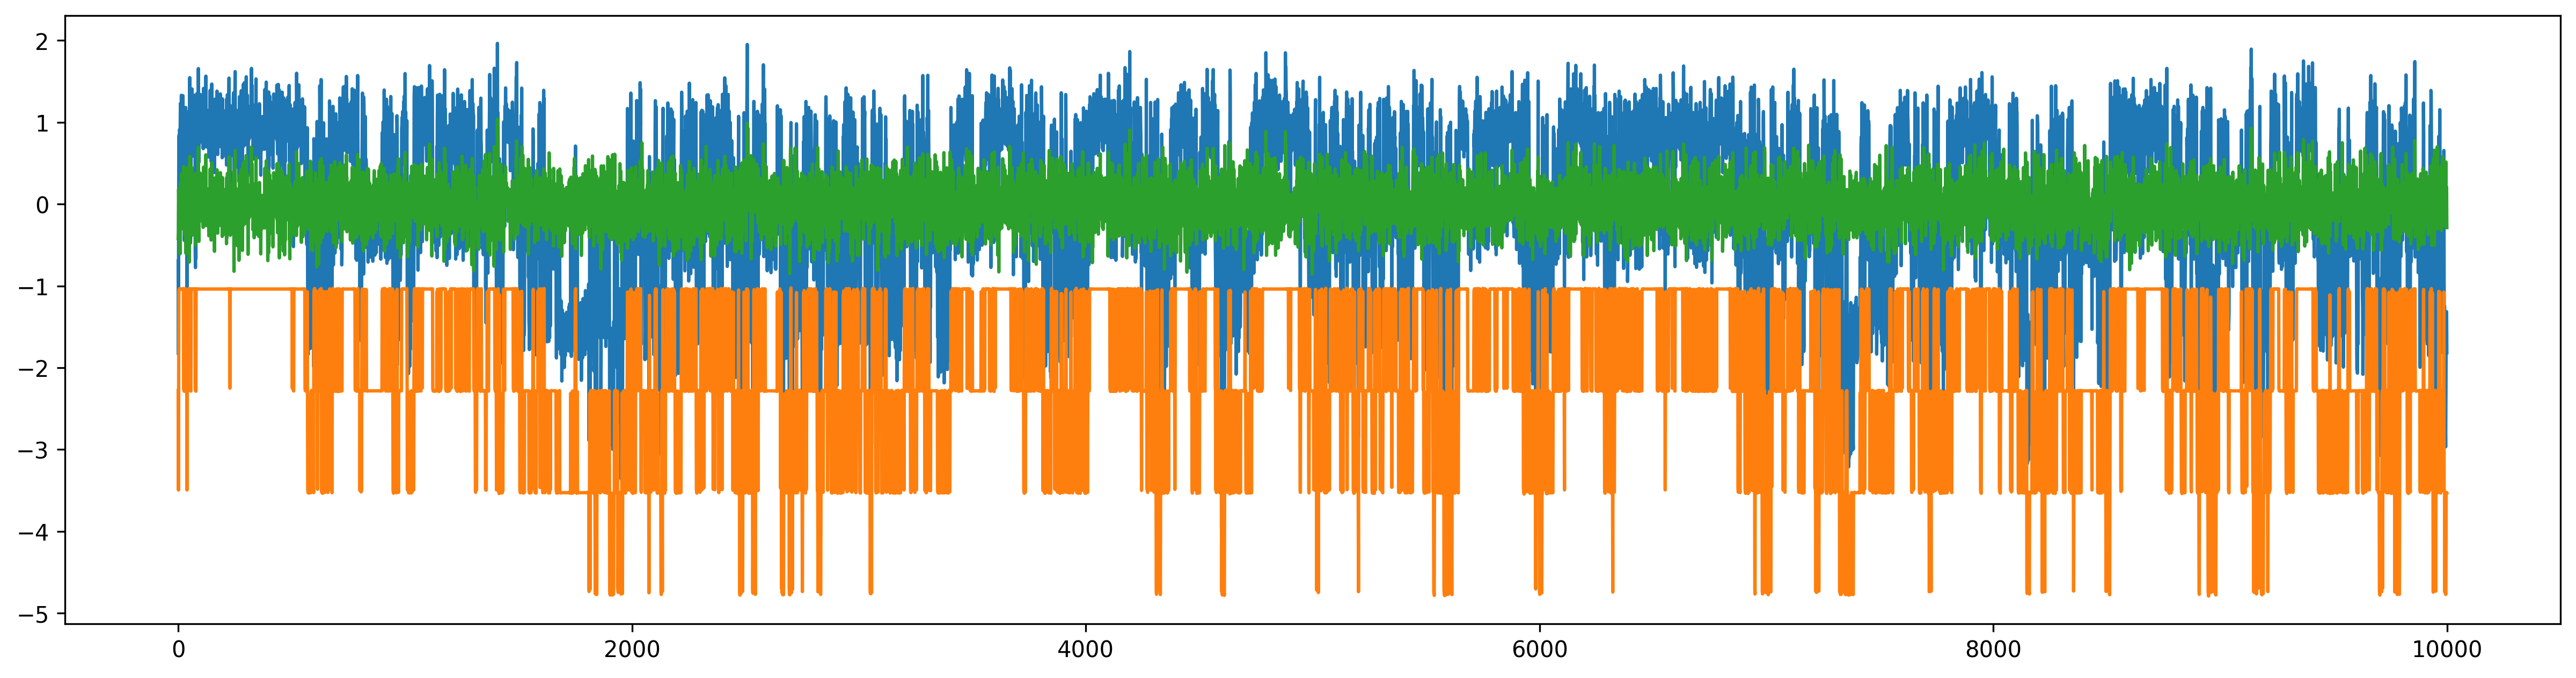

In [75]:
test_types_std = defaultdict(list)
st,sl=5000,10000
for s in [1]:
    xs = test_dl.dataset.data[0,s,:]
    ys = open_channels.view(-1,TEST_SEGMENT_SIZE)[s]
    x_pred = get_synth_segment_xy(None,None,size=TEST_SEGMENT_SIZE,y=ys,add_noise=False)[0]
    residual = xs-x_pred
    l = slice(st,st+sl)
    plt.plot(xs[l])
    plt.plot(x_pred[l]-2)
    plt.plot(residual[l])
    std = (residual).std().item()
    print(std)
    test_types_std[tt].append((xs-x_pred).std())
    #plt.plot(x_pred)
residual.abs().argmax()

In [76]:
test_types_std

defaultdict(list, {('h', 10): [tensor(0.2699)]})

In [77]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

'conv_swift_6638603_t5000000_v2000_BS512_SS500000_WS1000_pucv0.945299_prcv0.941465_trcv0.943609_clean_synth_clean50hz_n_tta5.csv'

In [78]:
open_channels_shifted = open_channels.clone()
#open_channels_shifted[:-1] = open_channels[1:]
#open_channels_shifted[-1]  = open_channels[0]

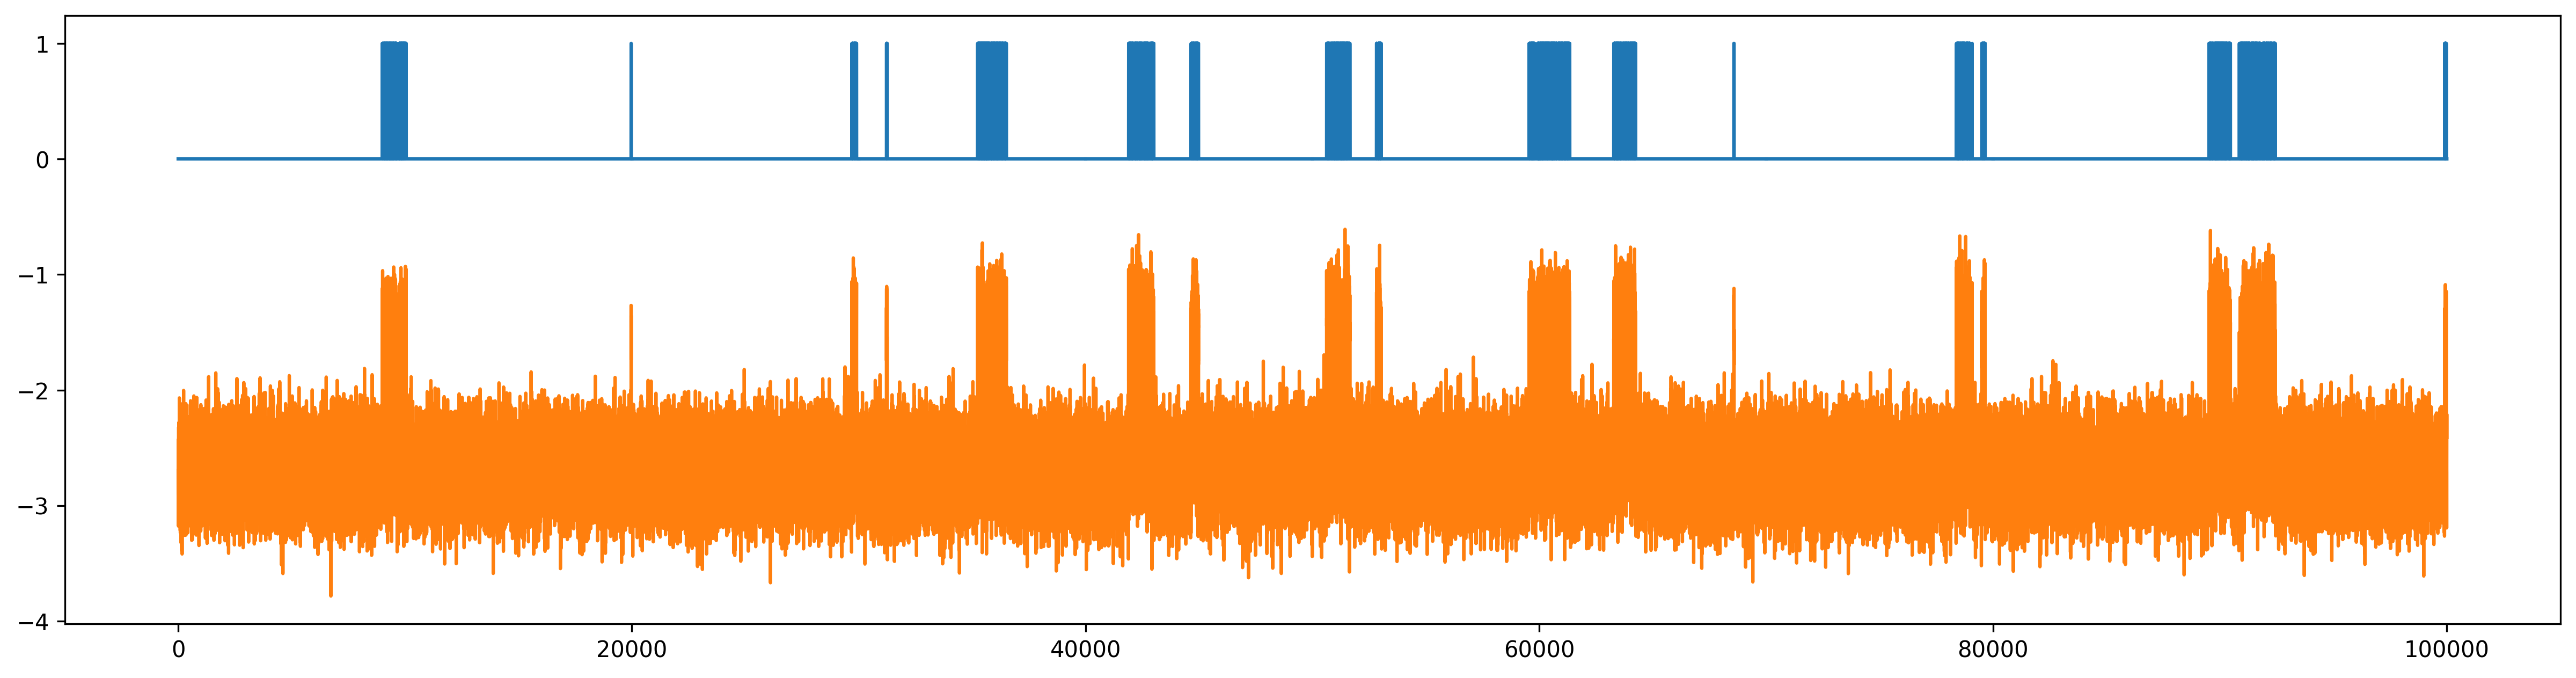

In [79]:
plt.plot(open_channels_shifted[:TEST_SEGMENT_SIZE])
plt.plot(test.flatten()[:TEST_SEGMENT_SIZE])

In [80]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels_shifted})
test_pred_frame.to_csv(csv_fname, index=False)

In [81]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'PU {public_cv} PR {private_cv} TR {train_cv}'

100%|██████████████████████████████████████| 21.0M/21.0M [00:04<00:00, 4.45MB/s]
Successfully submitted to University of Liverpool - Ion Switching